In [11]:
import yaml
import numpy as np
import pylab as plt
from math import *
from types import *
from operator import itemgetter
from inspect import getargspec
from iminuit import Minuit,util
%matplotlib inline

As an exercise, I try to build an object that takes any two functions $f(x, a)$ and $g(x, b)$ and minimizes their products. The parameters $a$ and $b$ should not be hardcode.  
Below, I write some example functions, all depending on $x$ plus additional, different parameter(s): $a, b, c, d, e, f, ...$

In [12]:
def f(x, a):
    return np.tanh(x*a)

def g(x, b):
    return np.power(x,b)

def h(x, c, d):
    return x*c+np.cos(x)

def j(x, e, f):
    return e*np.power(x,f)

I plot the behaviour of the product $f(x, 2) g(x, 3)$

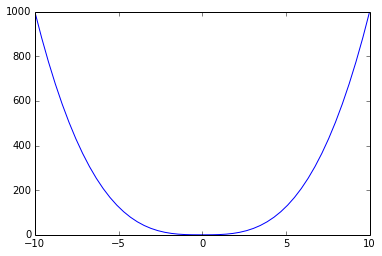

In [13]:
x_arr = np.linspace(-10,10)
plt.plot(x_arr,f(x_arr,2)*g(x_arr,3));
#plt.plot(x_arr,f(x_arr,2)*h(x_arr,3,2));
#plt.plot(x_arr,j(x_arr,2,1)*h(x_arr,3,2));

Given that in a likelihood minimisation the function object already contains the data and is a function of the free parameters only, I create a class.  

When an object is istantiated, the two external functions (eg. f,g) and their signature are saved as class variables. This way, their parameters need not be hardcoded

In [53]:
class func_def(object):
    __name__ = 'func_def'
    def __init__(self, data, *args):
        self.data = data
        self.func_a = args[0]
        self.func_b = args[1]
        self.arg_a = getargspec(self.func_a)[0][1:]
        self.arg_b = getargspec(self.func_b)[0][1:]
        self.params = list(set(self.arg_a)|set(self.arg_b))
    
    def __call__(self, **kwargs):
        arg_a = itemgetter(*self.arg_a)(kwargs)
        arg_b = itemgetter(*self.arg_b)(kwargs)
        is_arg_a_tpl = isinstance(arg_a, TupleType)
        is_arg_b_tpl = isinstance(arg_b, TupleType)
        
        if is_arg_a_tpl and is_arg_b_tpl:
            term1 = self.func_a(self.data,*arg_a)
            term2 = self.func_b(self.data,*arg_b)
            return sum(term1 * term2)
        
        elif not is_arg_a_tpl and is_arg_b_tpl:
            term1 = self.func_a(self.data,arg_a)
            term2 = self.func_b(self.data,*arg_b)
            return sum(term1 * term2)
        
        elif is_arg_a_tpl and not is_arg_b_tpl:
            term1 = self.func_a(self.data,*arg_a)
            term2 = self.func_b(self.data,arg_b)
            return sum(term1 * term2)
        
        elif not is_arg_a_tpl and not is_arg_b_tpl:
            term1 = self.func_a(self.data,arg_a)
            term2 = self.func_b(self.data,arg_b)
            return sum(term1 * term2)

Problem: in the definition of the class variables *self.arg_a* and *self.arg_b*, it is assumed that the first variable corresponds to the data  

There is a long set of conditional statements. These are necessary to unpack correctly the arguments lists of the two function.  
An alternative would be include the *x* argument into such lists, so by writing *self.arg_a = getargspec(self.func_a)[0]* in the *init* method but then the *call* method would require calling the function object with *x* argument too, unless I modify *arg_a = itemgetter(* **self.arg_a)(kwargs)*

Below I initiate various objects containing the data array and any two of the functions defined above, whose product shuold be minimised.

In [47]:
F = func_def(x_arr,f,g)
F(a=1,b=3)

13266.926692422941

In [48]:
G = func_def(x_arr,f,h)
G(a=1,c=3,d=4)

759.15894915185561

In [49]:
H = func_def(x_arr,h,g)
H(c=1,d=2,b=3)

108272.06351095208

In [50]:
J = func_def(x_arr,h,j)
J(c=1,d=2,e=3,f=4)

-141694.17241534666

Problem: how can I evaluate the function object with arguments the free arguments of the included functions?

In [19]:
settings = {s : 1 for s in F.params}
settings.update({'error_%s'%s : 0.01 for s in F.params})
print settings

{'a': 1, 'b': 1, 'error_a': 0.01, 'error_b': 0.01}


A possible solution could be to use the functionalities of the class *decorator*, in particular its attribute *FunctionMaker*, to create a new function with the desired signature

In [21]:
from decorator import FunctionMaker as FM

In [54]:
nf = FM(H,signature=H.params)

In [41]:
def proxy_func(*args):
    return self.loglike(*args)

In [42]:
strargs = ", ".join(F.params) 
nf.make(proxy_func)

TypeError: unsupported operand type(s) for %: 'function' and 'dict'

In [45]:
nf.__dict__

{'doc': None,
 'module': '__main__',
 'name': 'func_def',
 'shortsignature': ['a', 'b'],
 'signature': ['a', 'b']}

In [11]:
new_funcF = FM.create(('new_func('+", ".join(["%s = 1."] * len(F.params))+')') % tuple(F.params),
                     ('F('+", ".join(["%s = 1."] * len(F.params))+')') % tuple(F.params),dict(F=F))

In [12]:
print ('F('+", ".join(["%s = 1."] * len(F.params))+')') % tuple(F.params)
print ('new_func('+", ".join(["%s = 1."] * len(F.params))+')') % tuple(F.params)

F(a = 1., b = 1.)
new_func(a = 1., b = 1.)


With this long expression, I can build the correct string for the new function definition with *FunctionMaker.create* attribute

In [13]:
type(new_funcF)

function

I check that the new function has the correct signature

In [14]:
getargspec(new_funcF)[0]

['a', 'b']

I check that this scheme works for functions with more arguments

In [15]:
new_funcH = FM.create(('new_func('+", ".join(["%s = 1."] * len(H.params))+')') % tuple(H.params),
                     ('F('+", ".join(["%s = 1."] * len(H.params))+')') % tuple(H.params),dict(F=F))

In [16]:
getargspec(new_funcH)[0]

['c', 'b', 'd']

Now *new_funcF* has the derised signature: it depends on the free parameters of the functions with which the object *F* is instantiated, *a, b*

I feed it to Minuit, building first an arbitrary *settings* dictionary

In [17]:
settings = {s : 1 for s in F.params}
settings.update({'error_%s'%s : 0.01 for s in F.params})
print settings

{'a': 1, 'b': 1, 'error_a': 0.01, 'error_b': 0.01}


In [20]:
freeparams = F.params

In [25]:
m = Minuit(lambda freeparams : F(freeparams), errordef=0.5, **settings)

RuntimeError: Cannot understand keyword a. May be a typo?
The parameters are ['freeparams']

I call *migrad* to minimize the function object

In [23]:
m.migrad()

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:1: RuntimeWarning: Cannot convert fcn(*arg) to double 
fcn is called with following arguments:
    a = +1.000000
    b = +1.000000

  if __name__ == '__main__':


TypeError: a float is required

In [63]:
class test(object):
    def __init__(self, func):
        self.func = func
        self.var = getargspec(func)[0]
    
    def fit(self):
        x = self.var
        f = Minuit(lambda x : self.func(x), errordef=0.5, x=3, error_x=0.01)
        resfit = f.migrad()
        return resfit

In [64]:
parabola = test(lambda x : x**2)

In [65]:
parabola.fit()

FCN = 9.51267866748e-18 
 TOTAL NCALL = 13 
 NCALLS = 13 
 
 
 EDM = 9.51267866748e-18 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 x 
 3.084263e-09 
 7.071068e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & x & 3.084e-09 & 7.071e-01 & & & & & \\
\hline
\end{tabular}

({'hesse_failed': False, 'has_reached_call_limit': False, 'has_accurate_covar': True, 'has_posdef_covar': True, 'up': 0.5, 'edm': 9.512678667476046e-18, 'is_valid': True, 'is_above_max_edm': False, 'has_covariance': True, 'has_made_posdef_covar': False, 'has_valid_parameters': True, 'fval': 9.51267866748233e-18, 'nfcn': 13},
 [{'is_const': False, 'name': 'x', 'has_limits': False, 'value': 3.0842630671656934e-09, 'number': 0, 'has_lower_limit': False, 'upper_limit': 0.0, 'lower_limit': 0.0, 'has_upper_limit': False, 'error': 0.7071067811865476, 'is_fixed': False}])